# PCA and multiple time slices as input

In this experiment we want to reduce dimensionality of our input features using PCA.

Besides that we will try to use multiple time slices as an input for our XGBoost model.

In [52]:
import pandas as pd
import seaborn as sns
import shap
from matplotlib import pyplot as plt
import monipy.utils.database as database
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

### 1. Helping Functions

In [53]:
def load_and_prep_data(window=0, data_filter=4):
    # load data
    df = pd.concat([pd.read_csv(f"data/useable_yes_unknown/filter_{data_filter}/sandor_full.csv", index_col=[0]),
              pd.read_csv(f"data/useable_yes/filter_{data_filter}/ukt_full.csv", index_col=[0]),
              pd.read_csv(f"data/useable_yes/filter_{data_filter}/freiburg_full.csv", index_col=[0]),
              pd.read_csv(f"data/useable_yes/filter_{data_filter}/uka_corvolution_full.csv", index_col=[0]),
              pd.read_csv(f"data/useable_yes/filter_{data_filter}/uka_klinik_full.csv", index_col=[0]),
              ])
    
    # rename column
    df = df.rename(columns={"window_Unnamed: 2093_level_1": "window"})
    
    # filter for one starting window
    df = df[df["window"] == window]
    
    # get patient specific columns
    df_patients_columns = database.get_all_patients().columns
    
    # drop patient specific columns and other columns
    df = df.drop(columns = list(df_patients_columns))

    columns = ["seizure_id_Unnamed: 2091_level_1", 
           "record_id", "window", 
           "timestamp_start_Unnamed: 2094_level_1"]
    df = df.drop(columns=columns)

    return df

In [54]:
def train_test_val_split(df):
    # split the data val, test, train
    val_patients = pd.read_csv("data/patients/val_patients_1.csv", index_col=[0]).reset_index(drop=True)
    test_patients = pd.read_csv("data/patients/test_patients_1.csv", index_col=[0]).reset_index(drop=True)
    
    df_val = df[df["patient_id"].isin(val_patients.iloc[:, 0])].reset_index(drop=True)
    df_test = df[df["patient_id"].isin(test_patients.iloc[:, 0])].reset_index(drop=True)
    df_train = df[~(df["patient_id"].isin(set(val_patients.iloc[:, 0]) | set(test_patients.iloc[:, 0])))].reset_index(drop=True)
    return df_val, df_test, df_train

In [55]:
def create_splits(df_train, df_test, df_val, features, time_slice=0):
    data_split = {}
    for split in ["val", "test", "train"]:
        data_split[f"X_{split}"] = eval(f"df_{split}")[[f"{feature}_{time_slice}" for feature in features]]
        data_split[f"y_{split}"] = eval(f"df_{split}")[["seizure"]]
    return data_split["X_train"], data_split["y_train"], data_split["X_test"], data_split["y_test"], data_split["X_val"], data_split["y_val"]

In [56]:
# fit xgboost model
def fit_and_eval(X_train, y_train, X_test, y_test):
    # Define initial hyperparameters
    params = {
        'objective': 'binary:logistic',  # Binary classification objective
        'learning_rate': 0.1,  # Learning rate
        'max_depth': 7, # Maximum depth of each tree
        'n_estimators': 300,
        'subsample': 0.8,  # Subsample ratio of the training instances
        'colsample_bytree': 0.8,  # Subsample ratio of features when constructing each tree
        'scale_pos_weight': 0.9,
    }

    # Create the XGBoost classifier
    model = XGBClassifier(**params)

    # Train the XGBoost model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # return evaluation
    return model, (accuracy_score(y_test, y_pred), confusion_matrix(y_test, y_pred), classification_report(y_test, y_pred),recall_score(y_test, y_pred),recall_score(y_test, y_pred, pos_label=0))

In [57]:
features = {'avg',
 'csi',
 'csi_filtered',
 'csi_filtered_slope',
 'csi_slope',
 'csim',
 'csim_filtered',
 'csim_filtered_slope',
 'csim_slope',
 'cvi',
 'hf',
 'hr_diff',
 'hr_diff_filtered',
 'hr_diff_filtered_slope',
 'hr_diff_slope',
 'kurt',
 'lf',
 'lf_hf_ratio',
 'mf_coef_center',
 'mf_coef_left',
 'mf_coef_right',
 'mf_hurst_max',
 'nnx',
 'pnnx',
 'quantile_25',
 'quantile_50',
 'quantile_75',
 'rmssd',
 'rmssd_dt',
 'sd',
 'sd1',
 'sd2',
 'skew',
 'total_power',
 'triangular_index',
 'ulf',
 'variance',
 'vlf'}

### 2. Load Data

In [58]:
df = load_and_prep_data()
print(df.shape)
df_val, df_test, df_train = train_test_val_split(df)

[creating new connection]
(3320, 2092)


### 3. First time slice as input

#### 3.1. Test PCA for first time slice


In [59]:
X_train, y_train, X_test, y_test, X_val, y_val = create_splits(df_train, df_test, df_val, features, 0)

In [60]:
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)

In [61]:
scaler = StandardScaler()
X_test_norm = scaler.fit_transform(X_test)

In [62]:
scaler = StandardScaler()
X_val_norm = scaler.fit_transform(X_val)

In [63]:
pca = PCA(n_components=2)
pca.fit(X_train_norm)
pca_train = pca.transform(X_train_norm)
pca_train_df = pd.DataFrame(pca_train)

In [64]:
pca = PCA(n_components=2)
pca.fit(X_test_norm)
pca_test = pca.transform(X_test_norm)
pca_test_df = pd.DataFrame(pca_test)

In [65]:
# fit model for using principal components
model, (accuracy, cm, cr, recall_1, recall_0) = fit_and_eval(pca_train_df, y_train, pca_test_df, y_test)

In [66]:
print(cr)

              precision    recall  f1-score   support

           0       0.82      1.00      0.90       296
           1       0.98      0.44      0.61       115

    accuracy                           0.84       411
   macro avg       0.90      0.72      0.76       411
weighted avg       0.87      0.84      0.82       411



In [67]:
model, (accuracy, cm, cr, recall_1, recall_0) = fit_and_eval(X_train, y_train, X_test, y_test)

In [68]:
print(cr)

              precision    recall  f1-score   support

           0       0.92      0.99      0.95       296
           1       0.96      0.78      0.86       115

    accuracy                           0.93       411
   macro avg       0.94      0.88      0.91       411
weighted avg       0.93      0.93      0.93       411



#### 3.2. Test different numbers of PCA components

In [69]:
df = load_and_prep_data()
df_val, df_test, df_train = train_test_val_split(df)

X_train, y_train, X_test, y_test, X_val, y_val = create_splits(df_train, df_test, df_val, features, 0)

scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
scaler = StandardScaler()
X_test_norm = scaler.fit_transform(X_test)
scaler = StandardScaler()
X_val_norm = scaler.fit_transform(X_val)

pca_performance = []

for i in range(1,6,1):
    pca = PCA(n_components=i)
    pca.fit(X_train_norm)
    pca_train = pca.transform(X_train_norm)
    pca_train_df = pd.DataFrame(pca_train)

    pca = PCA(n_components=i)
    pca.fit(X_test_norm)
    pca_test = pca.transform(X_test_norm)
    pca_test_df = pd.DataFrame(pca_test)

    model, (accuracy, cm, cr, recall_1, recall_0) = fit_and_eval(pca_train_df, y_train, pca_test_df, y_test)
    
    pca_performance.append(
        {
        "n_components": i,
        "accuracy": accuracy,
        "confusion_matrix": cm,
        "report": cr,
        "recall_1": recall_1,
        "recall_0": recall_0
        }
    )

[creating new connection]


In [70]:
df_pca_performance = pd.DataFrame(pca_performance)

In [71]:
df_pca_performance

,n_components,accuracy,confusion_matrix,report,recall_1,recall_0
0,1,0.849148,"[[295, 1], [61, 54]]",precision recall f1-score ...,0.469565,0.996622
1,2,0.841849,"[[295, 1], [64, 51]]",precision recall f1-score ...,0.443478,0.996622
2,3,0.798054,"[[296, 0], [83, 32]]",precision recall f1-score ...,0.278261,1.000000
3,4,0.800487,"[[295, 1], [81, 34]]",precision recall f1-score ...,0.295652,0.996622
4,5,0.802920,"[[296, 0], [81, 34]]",precision recall f1-score ...,0.295652,1.000000


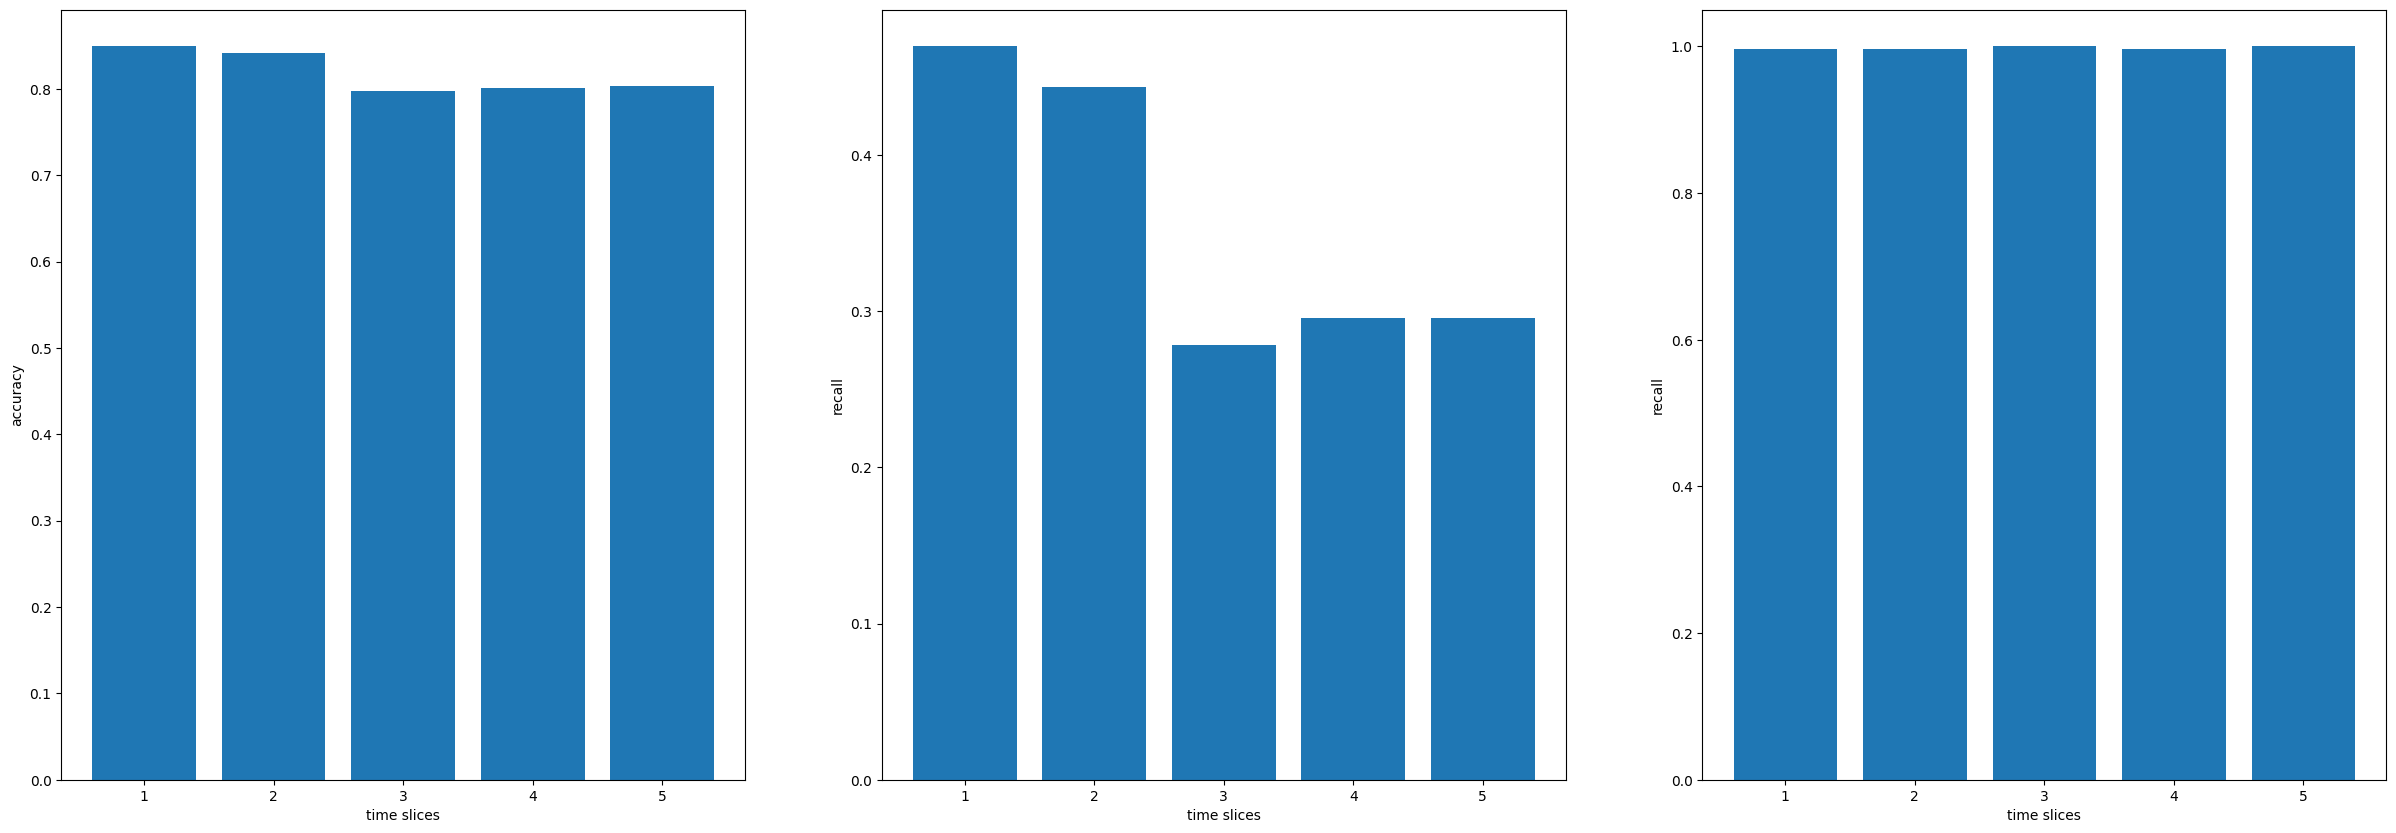

In [72]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(30,10))

ax1.bar(df_pca_performance["n_components"], df_pca_performance["accuracy"])
ax1.set_xlabel("time slices")
ax1.set_ylabel("accuracy")

ax2.bar(df_pca_performance["n_components"], df_pca_performance["recall_1"])
ax2.set_xlabel("time slices")
ax2.set_ylabel("recall")

ax3.bar(df_pca_performance["n_components"], df_pca_performance["recall_0"])
ax3.set_xlabel("time slices")
ax3.set_ylabel("recall")

fig.savefig("pca_eval.png")

### 4. All time slices as input

##### 4.1. Test PCA for all time slices as input

In [73]:
df = load_and_prep_data()
df_val, df_test, df_train = train_test_val_split(df)

[creating new connection]


In [74]:
X_train = df_train.drop(columns=["seizure", "patient_id"])
y_train = df_train.seizure

X_test = df_test.drop(columns=["seizure", "patient_id"])
y_test = df_test.seizure

X_val = df_val.drop(columns=["seizure", "patient_id"])
y_val = df_val.seizure

In [75]:
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)

scaler = StandardScaler()
X_test_norm = scaler.fit_transform(X_test)

scaler = StandardScaler()
X_val_norm = scaler.fit_transform(X_val)

In [76]:
pca = PCA(n_components=2)
pca.fit(X_train_norm)
pca_train = pca.transform(X_train_norm)
pca_train_df = pd.DataFrame(pca_train)

In [77]:
pca = PCA(n_components=2)
pca.fit(X_test_norm)
pca_test = pca.transform(X_test_norm)
pca_test_df = pd.DataFrame(pca_test)

In [78]:
model, (accuracy, cm, cr, recall_1, recall_0) = fit_and_eval(pca_train, y_train, pca_test, y_test)

In [79]:
print(cr)

              precision    recall  f1-score   support

           0       0.75      0.97      0.84       296
           1       0.66      0.17      0.26       115

    accuracy                           0.74       411
   macro avg       0.70      0.57      0.55       411
weighted avg       0.72      0.74      0.68       411



In [80]:
print(cm)

[[286  10]
 [ 96  19]]


In [81]:
model, (accuracy, cm, cr, recall_1, recall_0) = fit_and_eval(X_train, y_train, X_test, y_test)

In [82]:
print(cr)

              precision    recall  f1-score   support

           0       0.90      1.00      0.95       296
           1       0.99      0.71      0.83       115

    accuracy                           0.92       411
   macro avg       0.94      0.85      0.89       411
weighted avg       0.92      0.92      0.91       411



In [83]:
print(cm)

[[295   1]
 [ 33  82]]


In [84]:
df_feature_importance = pd.DataFrame({
        "features": X_train.columns,
        "importance": model.feature_importances_
    })

In [85]:
df_feature_importance = df_feature_importance.sort_values(by="importance", ascending=False).reset_index(drop=True)

In [86]:
df_feature_importance.head(30)

,features,importance
0,csim_0,0.013950
1,csi_13,0.012451
2,csi_0,0.012171
3,pnnx_3,0.010723
4,hr_diff_13,0.009846
5,mf_coef_center_23,0.007149
6,rmssd_1,0.007119
7,csim_slope_49,0.006981
8,vlf_23,0.006869
9,quantile_50_28,0.006818


##### 4.2. Try different number of PCA components

In [87]:
df = load_and_prep_data()
df_val, df_test, df_train = train_test_val_split(df)

X_train = df_train.drop(columns=["seizure", "patient_id"])
y_train = df_train.seizure

X_test = df_test.drop(columns=["seizure", "patient_id"])
y_test = df_test.seizure

X_val = df_val.drop(columns=["seizure", "patient_id"])
y_val = df_val.seizure

scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
scaler = StandardScaler()
X_test_norm = scaler.fit_transform(X_test)
scaler = StandardScaler()
X_val_norm = scaler.fit_transform(X_val)

pca_performance = []

for i in range(1,16,1):
    pca = PCA(n_components=i)
    pca.fit(X_train_norm)
    pca_train = pca.transform(X_train_norm)
    pca_train_df = pd.DataFrame(pca_train)

    pca = PCA(n_components=i)
    pca.fit(X_test_norm)
    pca_test = pca.transform(X_test_norm)
    pca_test_df = pd.DataFrame(pca_test)

    model, (accuracy, cm, cr, recall_1, recall_0) = fit_and_eval(pca_train_df, y_train, pca_test_df, y_test)
    
    pca_performance.append(
        {
        "n_components": i,
        "accuracy": accuracy,
        "confusion_matrix": cm,
        "report": cr,
        "recall_1": recall_1,
        "recall_0": recall_0
        }
    )

[creating new connection]


In [88]:
df_pca_performance = pd.DataFrame(pca_performance)

In [89]:
df_pca_performance

,n_components,accuracy,confusion_matrix,report,recall_1,recall_0
0,1,0.715328,"[[285, 11], [106, 9]]",precision recall f1-score ...,0.078261,0.962838
1,2,0.742092,"[[286, 10], [96, 19]]",precision recall f1-score ...,0.165217,0.966216
2,3,0.776156,"[[286, 10], [82, 33]]",precision recall f1-score ...,0.286957,0.966216
3,4,0.783455,"[[290, 6], [83, 32]]",precision recall f1-score ...,0.278261,0.979730
4,5,0.778589,"[[289, 7], [84, 31]]",precision recall f1-score ...,0.269565,0.976351
5,6,0.759124,"[[290, 6], [93, 22]]",precision recall f1-score ...,0.191304,0.979730
6,7,0.763990,"[[290, 6], [91, 24]]",precision recall f1-score ...,0.208696,0.979730
7,8,0.768856,"[[290, 6], [89, 26]]",precision recall f1-score ...,0.226087,0.979730
8,9,0.756691,"[[289, 7], [93, 22]]",precision recall f1-score ...,0.191304,0.976351
9,10,0.754258,"[[289, 7], [94, 21]]",precision recall f1-score ...,0.182609,0.976351


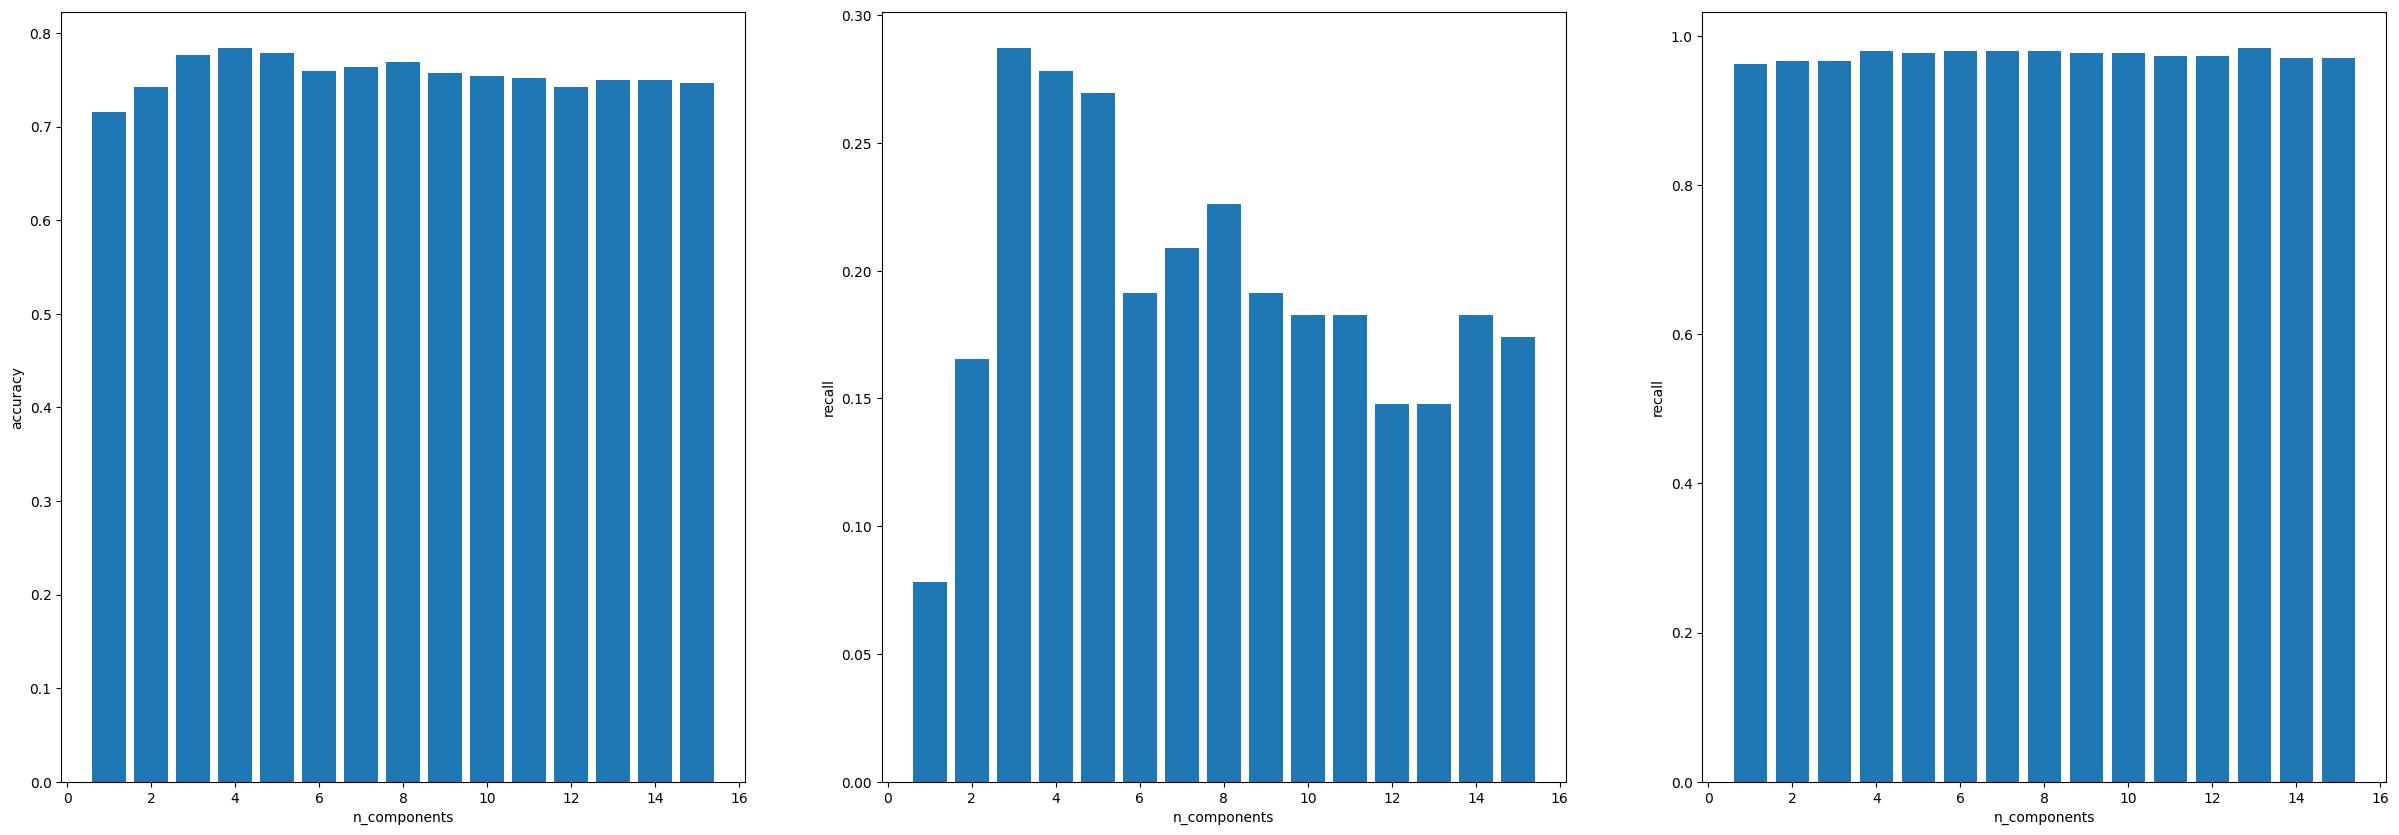

In [90]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(30,10))

ax1.bar(df_pca_performance["n_components"], df_pca_performance["accuracy"])
ax1.set_xlabel("n_components")
ax1.set_ylabel("accuracy")

ax2.bar(df_pca_performance["n_components"], df_pca_performance["recall_1"])
ax2.set_xlabel("n_components")
ax2.set_ylabel("recall")

ax3.bar(df_pca_performance["n_components"], df_pca_performance["recall_0"])
ax3.set_xlabel("n_components")
ax3.set_ylabel("recall")

fig.savefig("pca_eval.png")

##### 4.3. Apply PCA on different time slices seperatly

In [91]:
df = load_and_prep_data()
df_val, df_test, df_train = train_test_val_split(df)

X_train = df_train.drop(columns=["seizure", "patient_id"])
y_train = df_train.seizure

X_test = df_test.drop(columns=["seizure", "patient_id"])
y_test = df_test.seizure

X_val = df_val.drop(columns=["seizure", "patient_id"])
y_val = df_val.seizure

scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
scaler = StandardScaler()
X_test_norm = scaler.fit_transform(X_test)
scaler = StandardScaler()
X_val_norm = scaler.fit_transform(X_val)

pca_performance = []

for i in range(1,16,1):
    pca = PCA(n_components=i)
    pca.fit(X_train_norm)
    pca_train = pca.transform(X_train_norm)
    pca_train_df = pd.DataFrame(pca_train)

    pca = PCA(n_components=i)
    pca.fit(X_test_norm)
    pca_test = pca.transform(X_test_norm)
    pca_test_df = pd.DataFrame(pca_test)

    model, (accuracy, cm, cr, recall_1, recall_0) = fit_and_eval(pca_train_df, y_train, pca_test_df, y_test)
    
    pca_performance.append(
        {
        "n_components": i,
        "accuracy": accuracy,
        "confusion_matrix": cm,
        "report": cr,
        "recall_1": recall_1,
        "recall_0": recall_0
        }
    )

[creating new connection]


In [92]:
df_pca_performance = pd.DataFrame(pca_performance)

In [93]:
df_pca_performance

,n_components,accuracy,confusion_matrix,report,recall_1,recall_0
0,1,0.715328,"[[285, 11], [106, 9]]",precision recall f1-score ...,0.078261,0.962838
1,2,0.742092,"[[286, 10], [96, 19]]",precision recall f1-score ...,0.165217,0.966216
2,3,0.776156,"[[286, 10], [82, 33]]",precision recall f1-score ...,0.286957,0.966216
3,4,0.788321,"[[292, 4], [83, 32]]",precision recall f1-score ...,0.278261,0.986486
4,5,0.771290,"[[288, 8], [86, 29]]",precision recall f1-score ...,0.252174,0.972973
5,6,0.759124,"[[290, 6], [93, 22]]",precision recall f1-score ...,0.191304,0.979730
6,7,0.763990,"[[290, 6], [91, 24]]",precision recall f1-score ...,0.208696,0.979730
7,8,0.761557,"[[289, 7], [91, 24]]",precision recall f1-score ...,0.208696,0.976351
8,9,0.751825,"[[288, 8], [94, 21]]",precision recall f1-score ...,0.182609,0.972973
9,10,0.766423,"[[290, 6], [90, 25]]",precision recall f1-score ...,0.217391,0.979730


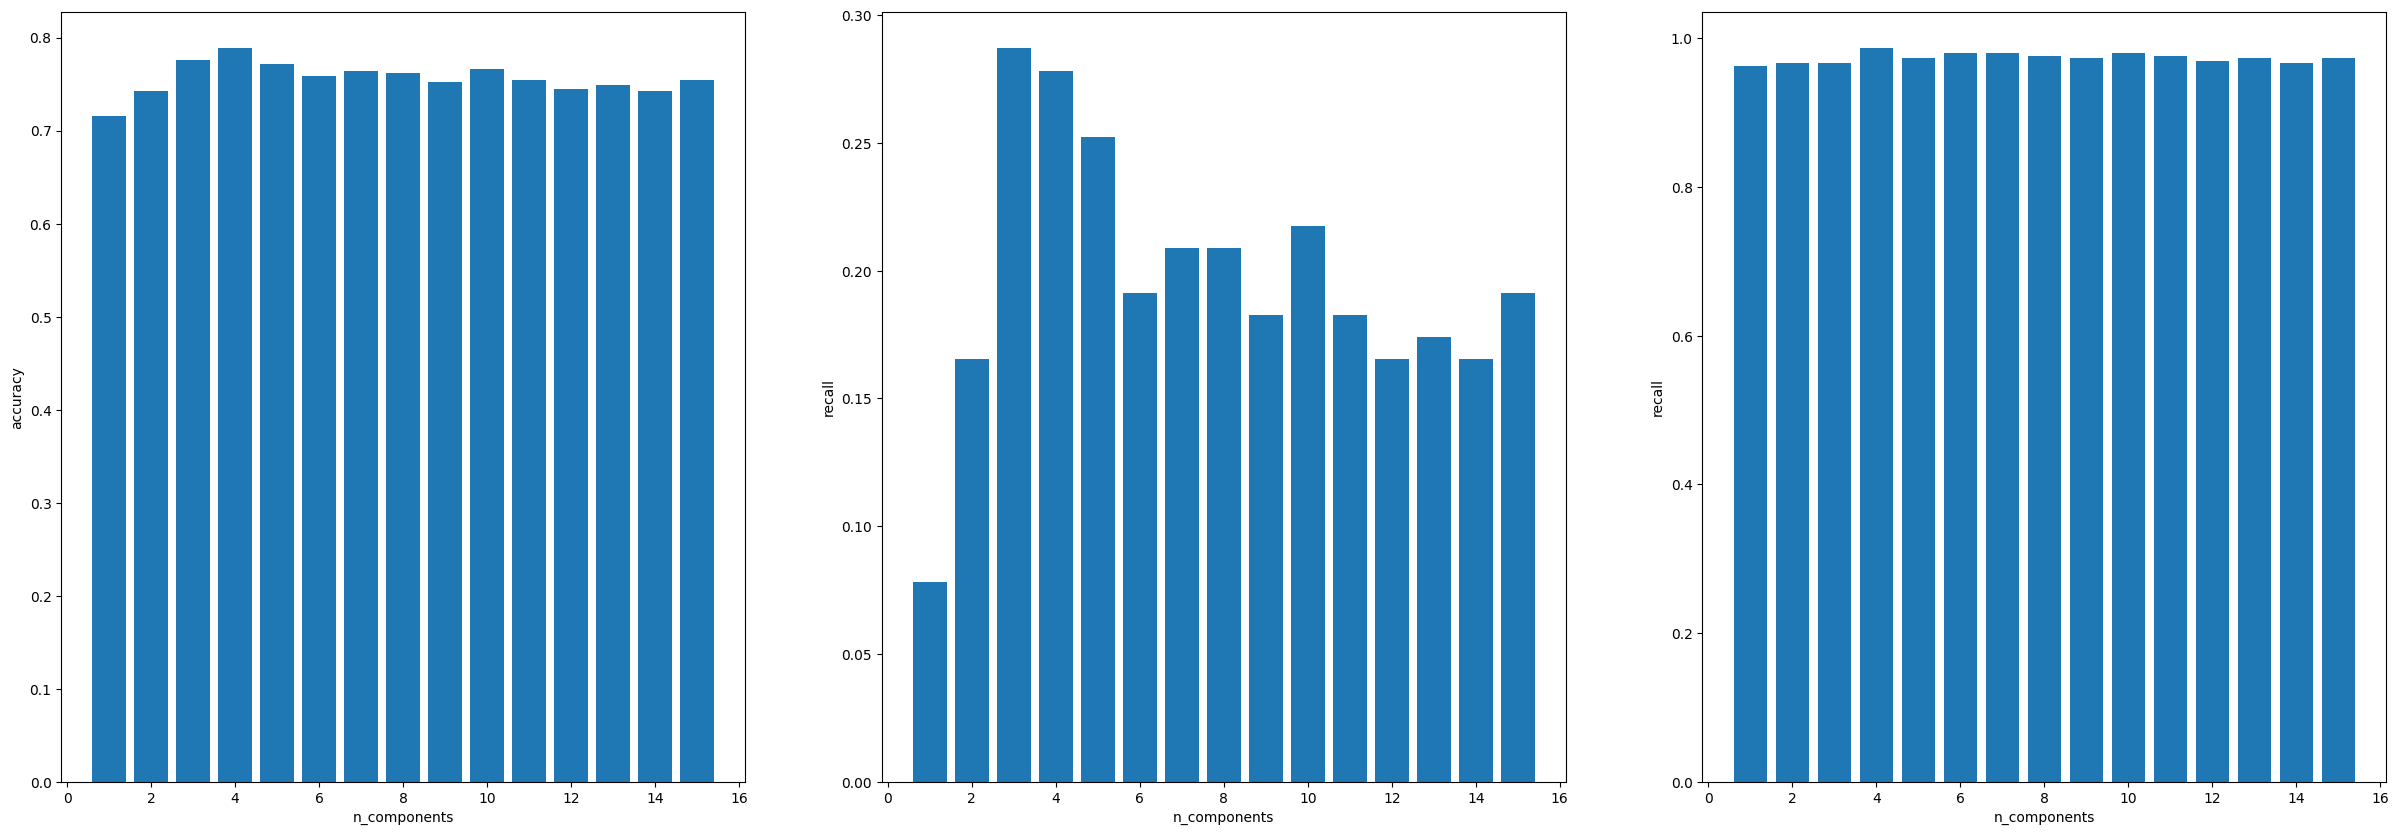

In [94]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(30,10))

ax1.bar(df_pca_performance["n_components"], df_pca_performance["accuracy"])
ax1.set_xlabel("n_components")
ax1.set_ylabel("accuracy")

ax2.bar(df_pca_performance["n_components"], df_pca_performance["recall_1"])
ax2.set_xlabel("n_components")
ax2.set_ylabel("recall")

ax3.bar(df_pca_performance["n_components"], df_pca_performance["recall_0"])
ax3.set_xlabel("n_components")
ax3.set_ylabel("recall")

fig.savefig("pca_eval.png")

In [95]:
df = load_and_prep_data()
df_val, df_test, df_train = train_test_val_split(df)

pca_train_df = pd.DataFrame()
pca_test_df = pd.DataFrame()

for i in range(0,55, 1):
    X_train, y_train, X_test, y_test, X_val, y_val = create_splits(df_train, df_test, df_val, features, i)

    scaler = StandardScaler()
    X_train_norm = scaler.fit_transform(X_train)
    scaler = StandardScaler()
    X_test_norm = scaler.fit_transform(X_test)
    scaler = StandardScaler()
    X_val_norm = scaler.fit_transform(X_val)

    pca = PCA(n_components=2)
    pca.fit(X_train_norm)
    pca_train = pca.transform(X_train_norm)
    pca_train = pd.DataFrame(pca_train).rename(columns={
        0: f"pca_0_time_slice_{i}",
        1: f"pca_1_time_slice_{i}"
    })
    pca_train_df = pca_train if pca_train_df.empty else pca_train_df.join(pca_train)

    pca = PCA(n_components=2)
    pca.fit(X_test_norm)
    pca_test = pca.transform(X_test_norm)
    pca_test = pd.DataFrame(pca_test).rename(columns={
        0: f"pca_0_time_slice_{i}",
        1: f"pca_1_time_slice_{i}"
    })
    pca_test_df = pca_test if pca_test_df.empty else pca_test_df.join(pca_test)

[creating new connection]


In [96]:
model, (accuracy, cm, cr, recall_1, recall_0) = fit_and_eval(pca_train_df, y_train, pca_test_df, y_test)

In [97]:
print(cr)

              precision    recall  f1-score   support

           0       0.77      1.00      0.87       296
           1       1.00      0.23      0.38       115

    accuracy                           0.79       411
   macro avg       0.89      0.62      0.63       411
weighted avg       0.83      0.79      0.73       411

